In [891]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib ipympl

In [892]:
def interp_coordinates_from_optical_path_length(opl_0, opl_1, z_0, z_1, x_0, x_1, opl_value):
    N = len(opl_0)
    opl = np.vstack([opl_0, opl_1]).T
    z = np.vstack([z_0, z_1]).T
    x = np.vstack([x_0, x_1]).T

    z_given_opl = np.empty(N)
    x_given_z = np.empty(N)

    fn_vectorized = np.vectorize(interp1d,
                                        signature='(n),(n)->()')
    # Generate array of interpolation functions for z from opl
    interp_fn_array_z_from_opl = fn_vectorized(opl, z)

    # Generate array of interpolation functions for x from z
    interp_fn_array_x_from_z = fn_vectorized(z, x)

    # Initialize arrays for results
    z_given_opl = np.empty(N)
    x_given_z = np.empty(N)

    # Evaluate the interpolated values
    for i in range(N):
        z_given_opl[i] = interp_fn_array_z_from_opl[i](opl_values[i])
        x_given_z[i] = interp_fn_array_x_from_z[i](z_given_opl[i])
        
    return z_given_opl, x_given_z
    

Convert Plane Wave Source to Spherical Wave in Focal Plane, with appropriate phase shifts. 

In [893]:

f = 10
N = 10
x0 = 4.0
do = -4
lens_z = 0.0
lens_f = 2.0
di = -1/((1/-lens_f) - (1/do))
M = di / do
chief_opl = np.abs(do) + di

rays_start_x = np.linspace(0.0, x0, N)
rays_start_z = np.linspace(do, do, N)
rays_slope = np.linspace(1.0, 1.0, N)
rays_angle = np.arctan(rays_slope)
d = np.cos(rays_angle) * rays_start_x 

dz = d * np.cos(rays_angle)
dx = d * np.sin(rays_angle)
dopl = np.sqrt(dz ** 2 + dx ** 2)

rays_start = np.array([rays_start_x, rays_slope])
rays_start_opl = np.zeros(N) + dopl
rays_start_opl[0] += 0

lens_mat = lambda f: np.array([[1, 0], [-1 / f, 1]])
prop_mat = lambda d: np.array([[1, d], [0, 1]])

rays_lens_z = rays_start_z + (lens_z - rays_start_z)
rays_focal_z = rays_lens_z + (lens_f)
rays_image_z = rays_focal_z + (di - lens_f)

rays_lens = np.matmul(prop_mat(lens_z - rays_start_z[0]), rays_start)
rays_lens = np.matmul(lens_mat(lens_f), rays_lens)
new_ray_angle = np.arctan(rays_lens[1, :])
rays_focal = np.matmul(prop_mat(lens_f), rays_lens)
rays_image = np.matmul(prop_mat(di - lens_f), rays_focal)

rays_start_lens_opl_left = rays_start_opl + np.sqrt((lens_z - rays_start_z) ** 2 + (rays_lens[0, :] - rays_start_x) ** 2)

focal_point_x = lens_f * rays_slope

opl_chief = np.sqrt(lens_f ** 2 + focal_point_x **2)

interface_distance_left = rays_lens[0, :] * np.sin(rays_angle)
interface_distance_right = rays_lens[0, :] * np.sin(new_ray_angle)

rays_lens_opl_right = (rays_start_lens_opl_left - rays_lens[0, :] * np.sin(rays_angle)) - np.sqrt(lens_f ** 2 + (rays_lens[0, :] - focal_point_x) ** 2)
rays_lens_focal_opl = rays_lens_opl_right + np.sqrt(lens_f ** 2 + (rays_lens[0, :] - focal_point_x) ** 2)
rays_lens_image_opl = rays_lens_focal_opl + np.sqrt((di - lens_f) ** 2 + (rays_focal[0, :] - rays_image[0, :]) **2) 

opl_values =  opl_chief #(rays_start_lens_opl_left - rays_lens[0, :] * np.sin(rays_angle))
z01_given_opl, x01_given_z = interp_coordinates_from_optical_path_length(rays_start_opl, rays_start_lens_opl_left, 
                                                                        rays_start_z, rays_lens_z,
                                                                        rays_start[0, :], rays_lens[0, :],
                                                                        opl_values)

opl_value = rays_lens_opl_right
z12_given_opl, x12_given_z = interp_coordinates_from_optical_path_length(rays_lens_opl_right, rays_lens_focal_opl, 
                                                                        rays_lens_z, rays_focal_z,
                                                                        rays_lens[0, :], rays_focal[0, :],
                                                                        opl_values)
# opl_value = 5
# z13_given_opl, x13_given_z = interp_coordinates_from_optical_path_length(rays_lens_focal_opl, rays_lens_image_opl, 
#                                                                         rays_focal_z, rays_image_z,
#                                                                         rays_focal[0, :], rays_image[0, :],
#                                                                         opl_values)

ValueError: A value (2.8567113959936523) in x_new is above the interpolation range's maximum value (2.8284271247461907).

[6.28036983e-16 6.28036983e-16 0.00000000e+00 4.96506831e-16
 9.93013661e-16 9.93013661e-16 0.00000000e+00 0.00000000e+00
 9.93013661e-16 0.00000000e+00]


(-4.4, 4.4, -4.6, 8.6)

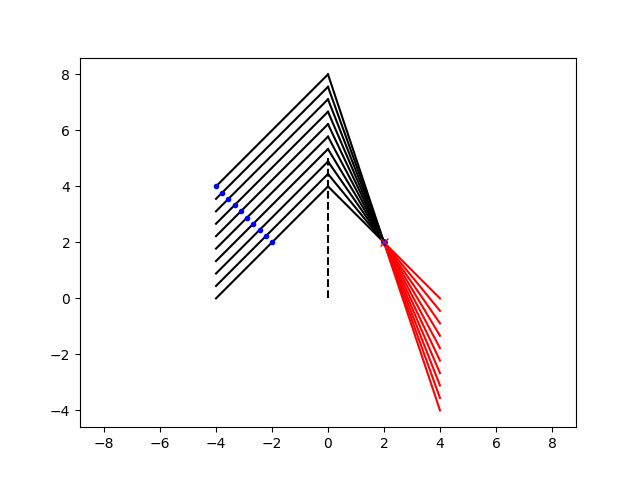

In [ ]:
plt.figure()
plt.vlines(0, 0, 5, color = 'k', linestyle = '--')
plt.plot([rays_start_z, rays_lens_z], [rays_start[0, :], rays_lens[0, :]], '-k')
plt.plot([rays_lens_z, rays_focal_z], [rays_lens[0, :], rays_focal[0, :]], '-k')
plt.plot([rays_focal_z, rays_image_z], [rays_focal[0, :], rays_image[0, :]], '-r')
plt.plot(z01_given_opl, x01_given_z, '.b')
plt.plot(z12_given_opl, x12_given_z, '.b')
# plt.plot(z13_given_opl, x13_given_z, '.b')
dist = np.sqrt((z12_given_opl - lens_f) ** 2 + (x12_given_z - focal_point_x) ** 2)
print(dist)
x = lens_f * rays_slope

plt.plot(lens_f, x[0], 'xr')
plt.axis('equal')

Convert Spherical Wave from Point object to Spherical Wave for Point Image. 

In [ ]:
f = 10
N = 10
x0 = 4.0
do = -4
lens_z = 0.0
lens_f = 2.0
di = -1/((1/-lens_f) - (1/do))
M = di / do
chief_opl = np.abs(do) + di

rays_start_x = np.linspace(0.0, 0.0, N)
rays_start_z = np.linspace(do, do, N)
rays_slope = np.linspace(0.0, 1, N)
rays_angle = np.arctan(rays_slope)
d = np.cos(rays_angle) * rays_start_x 

dz = d * np.cos(rays_angle)
dx = d * np.sin(rays_angle)
dopl = np.sqrt(dz ** 2 + dx ** 2)

rays_start = np.array([rays_start_x, rays_slope])
rays_start_opl = np.zeros(N) + dopl
lens_mat = lambda f: np.array([[1, 0], [-1 / f, 1]])
prop_mat = lambda d: np.array([[1, d], [0, 1]])

rays_lens_z = rays_start_z + (lens_z - rays_start_z)
rays_focal_z = rays_lens_z + (lens_f)
rays_image_z = rays_focal_z + (di - lens_f)

rays_lens = np.matmul(prop_mat(lens_z - rays_start_z[0]), rays_start)
rays_lens = np.matmul(lens_mat(lens_f), rays_lens)
rays_focal = np.matmul(prop_mat(lens_f), rays_lens)
rays_image = np.matmul(prop_mat(di - lens_f), rays_focal)

rays_start_lens_opl_left = rays_start_opl + np.sqrt((lens_z - rays_start_z) ** 2 + (rays_lens[0, :] - rays_start_x) ** 2)

focal_point_x = lens_f * rays_slope

opl_chief = np.sqrt(lens_f ** 2 + focal_point_x **2)

prop_dist_lens_to_focal_plane = np.sqrt(lens_f ** 2 + (rays_lens[0, :] - focal_point_x) ** 2)
rays_lens_opl_right = (rays_start_lens_opl_left - rays_lens[0, :] * np.sin(rays_angle)) - prop_dist_lens_to_focal_plane

new_ray_angle = np.arctan(rays_lens[1, :])
rays_lens_focal_opl = rays_lens_opl_right + prop_dist_lens_to_focal_plane
rays_lens_image_opl = rays_lens_focal_opl + np.sqrt((di - lens_f) ** 2 + (rays_focal[0, :] - rays_image[0, :]) **2) 
opl_oe = 4.0
 
opl_value = 4
z01_given_opl, x01_given_z = interp_coordinates_from_optical_path_length(rays_start_opl, rays_start_lens_opl_left, 
                                                                        rays_start_z, rays_lens_z,
                                                                        rays_start[0, :], rays_lens[0, :],
                                                                        opl_value)

opl_value = 2
z12_given_opl, x12_given_z = interp_coordinates_from_optical_path_length(rays_lens_opl_right, rays_lens_focal_opl, 
                                                                        rays_lens_z, rays_focal_z,
                                                                        rays_lens[0, :], rays_focal[0, :],
                                                                        opl_value)
opl_value = 5
z13_given_opl, x13_given_z = interp_coordinates_from_optical_path_length(rays_lens_focal_opl, rays_lens_image_opl, 
                                                                        rays_focal_z, rays_image_z,
                                                                        rays_focal[0, :], rays_image[0, :],
                                                                        opl_value)

ValueError: A value (2.8284271247461903) in x_new is below the interpolation range's minimum value (4.0).

(-4.4, 4.4, -0.25, 5.25)

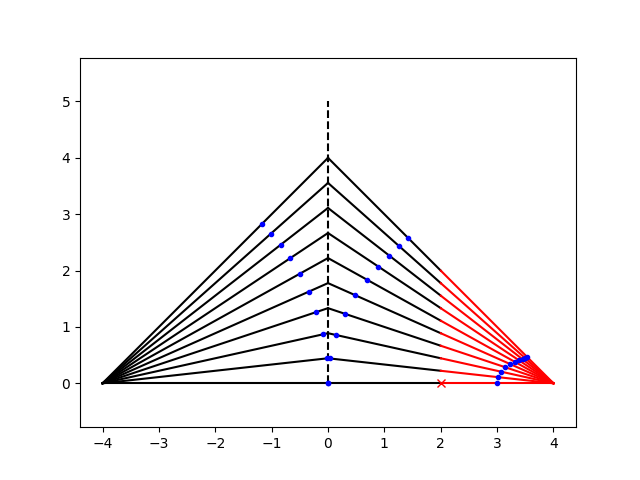

In [ ]:
plt.figure()
plt.vlines(0, 0, 5, color = 'k', linestyle = '--')
plt.plot([rays_start_z, rays_lens_z], [rays_start[0, :], rays_lens[0, :]], '-k')
plt.plot([rays_lens_z, rays_focal_z], [rays_lens[0, :], rays_focal[0, :]], '-k')
plt.plot([rays_focal_z, rays_image_z], [rays_focal[0, :], rays_image[0, :]], '-r')
plt.plot(z01_given_opl, x01_given_z, '.b')
plt.plot(z12_given_opl, x12_given_z, '.b')
plt.plot(z13_given_opl, x13_given_z, '.b')

x = lens_f * rays_slope

plt.plot(lens_f, x[0], 'xr')
plt.axis('equal')